### IS - Brand position
Finding Product position on Social Network (PPSN)

In [1]:
import networkx as nx
import numpy as np
import pandas as pd
import itertools
import math
import string
import json
import pymongo
from itertools import groupby

In [2]:
import gensim
import pyLDAvis.gensim
pyLDAvis.enable_notebook()

from pythainlp.corpus import thai_stopwords

# Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=pd.core.common.SettingWithCopyWarning)

C:\ProgramData\Anaconda3\lib\site-packages\past\types\oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Iterable
C:\ProgramData\Anaconda3\lib\site-packages\past\builtins\misc.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Mapping


In [3]:
# Connect MongoDB
myclient = pymongo.MongoClient("mongodb://localhost:27017/")
mydb = myclient["NIDA_PPSN_PRD"]
col_thread = mydb["NIDA_PPSN_THREAD"]
col_comment = mydb["NIDA_PPSN_COMMENT"]
col_claen = mydb["NIDA_PPSN_CLEANED_DATA"]

In [4]:
def reduced_keyword(wtkn,redCol):
    del_list = []
    ret_wtkn = wtkn
    for each in ret_wtkn:
        if each not in redCol:
            del_list.append(each)
    ret_wtkn = [x for x in ret_wtkn if x not in del_list]
    return ret_wtkn

### 3.Process หัวกระทู้เพื่อดึง Domain (Brand & Product) ไม่ใช้โมเดลเทรนแล้วทำนาย ต้องการความถูกต้อง 100%

In [5]:
cursor_clean = col_claen.find()
df_join_url = pd.DataFrame(cursor_clean)
df_join_url.set_index('commentId',inplace=True)
df_join_url.drop('_id', axis=1,inplace=True)

In [6]:
df_join_url

,URLs,token_headline,docs_mention_domain,docs_mention_brand,headline,article_date,text,token_text,token_text_cnt
commentId,,,,,,,,,
0,https://pantip.com/topic/39868603,"[นม, ซีพีเมจิ, รสหวาน, หายาก]","[[นม, 2]]","[[ซีพีเมจิ, 1]]",นมเมจิรสหวานทำไมหายากจังคะ,2020-05-05 13:22:59,เมื่อก่อนหลายปีมาแล้ว ในเซเว่นยังมีนมเมจิรสหวา...,"[ปี, 7-Eleven, ยังมี, นม, ซีพีเมจิ, รสหวาน, ขา...","[[7-Eleven, 1], [Tops, 1], [กลาง, 1], [ขวด, 2]..."
1,https://pantip.com/topic/39868603,"[นม, ซีพีเมจิ, รสหวาน, หายาก]","[[นม, 1]]","[[ซีพีเมจิ, 1]]",นมเมจิรสหวานทำไมหายากจังคะ,2020-05-05 13:22:59,เบาหวานครับ แฮ่ๆ,"[เบาหวาน, แฮ่]","[[เบาหวาน, 1], [แฮ่, 1]]"
2,https://pantip.com/topic/39868603,"[นม, ซีพีเมจิ, รสหวาน, หายาก]","[[นม, 1]]","[[ซีพีเมจิ, 1]]",นมเมจิรสหวานทำไมหายากจังคะ,2020-05-05 13:22:59,หาซื้อไม่ได้นี่คิดได้ 2 อย่างนะ. คนไม่ค่อย...,"[หาซื้อไม่ได้, คิดได้, , คน, กินกัน, ทำ, คน, น...","[[ขาย, 1], [คน, 2], [นิยม, 1], [รสหวาน, 1], [,..."
3,https://pantip.com/topic/39868603,"[นม, ซีพีเมจิ, รสหวาน, หายาก]","[[นม, 1]]","[[ซีพีเมจิ, 1]]",นมเมจิรสหวานทำไมหายากจังคะ,2020-05-05 13:22:59,เป็นรสที่ขายไม่ดีครับ\nรสพื้นฐานคือ\nจืด แบ่งย...,"[รส, ขายไม่ดี, รส, พื้นฐาน, จืด, แบ่ง, ไขมันต่...","[[ขายไม่ดี, 1], [คน, 1], [พื้นฐาน, 1], [รส, 2]..."
4,https://pantip.com/topic/39868603,"[นม, ซีพีเมจิ, รสหวาน, หายาก]","[[นม, 1]]","[[ซีพีเมจิ, 1]]",นมเมจิรสหวานทำไมหายากจังคะ,2020-05-05 13:22:59,ถ้าขายไม่ดีเค้าก็เอาออกครับ shelf life มันน้อย...,"[ขายไม่ดี, เค้า, shelf life, เวลา, หมดอายุ, ค่...","[[ขวด, 1], [ขายไม่ดี, 2], [กี่, 1], [ซื้อ, 1],..."
...,...,...,...,...,...,...,...,...,...
12541,https://pantip.com/topic/30023475,"[นม, ถุง, ขาย, โรงเรียน, ขาย, ที่อื่น, กทม, ไห...","[[นม, 1]]","[[ไทยเดนมาร์ค, 2]]",นมถุง ที่ขายในโรงเรียน มีขายที่อื่นในกทม.อีกไห...,2013-01-07 17:36:47,นมวัวแดง น่าจะเป็นชื่อเรียกของยี่ห้อ ไทย-เดนมา...,"[ไทยเดนมาร์ค, น่าจะเป็น, ชื่อ, ยี่ห้อ, ไทยเดนม...","[[ยี่ห้อ, 1], [ไทยเดนมาร์ค, 2], [วัว, 1], [ชื่..."
12542,https://pantip.com/topic/30023475,"[นม, ถุง, ขาย, โรงเรียน, ขาย, ที่อื่น, กทม, ไห...","[[นม, 1]]",None,นมถุง ที่ขายในโรงเรียน มีขายที่อื่นในกทม.อีกไห...,2013-01-07 17:36:47,เมื่อก่อนตอนเด็กๆค่จำได้นะว่านมถุงละ5บาทเองอะ\...,"[ตอน, เด็ก, ๆค่, จำได้, นม, ถุง, อะ, ซื้อ, สหก...","[[นม, 1], [ซื้อ, 1], [ตอน, 1], [เด็ก, 1], [อะ,..."
12543,https://pantip.com/topic/30023475,"[นม, ถุง, ขาย, โรงเรียน, ขาย, ที่อื่น, กทม, ไห...","[[นม, 1]]",None,นมถุง ที่ขายในโรงเรียน มีขายที่อื่นในกทม.อีกไห...,2013-01-07 17:36:47,ตกลงได้ไปซื้อมาแล้วนะคะที่เกษตร หลงทางอยู่ในม....,"[ตกลง, ซื้อ, เกษตร, หลงทาง, เกษตร, แห, เจอ, อร...","[[หาย, 1], [กิน, 1], [ซื้อ, 1], [ขอบคุณ, 1], [..."


###  4. (ยกเลิกแต่เก็บ code) คัดเลือกคำมาเป็น Attribute ด้วย TF-IDF

In [7]:
#import gensim
#from gensim.models import TfidfModel

In [8]:
# Create Bag of Word & calculate TF-IDF
#dictionary = gensim.corpora.Dictionary(df_join_url['token_text'])
#gensim_corpus = [dictionary.doc2bow(text, allow_update=True) for text in df_join_url['token_text']]
#model = TfidfModel(gensim_corpus)
#vector = model[gensim_corpus]
#word_frequencies = [[(dictionary[id], tfidf_val) for id, tfidf_val in couple] for couple in vector]

In [9]:
#for i in range(0,len(word_frequencies)):
#    word_frequencies[i].sort(key=lambda tup:(-tup[1], tup[0]))  # SORT LIST of TUPLE DESCENDINGLY
#    word_frequencies[i] = word_frequencies[i][:10]   

In [10]:
# List complehension : get the first element of each tuple in a list
# https://www.kite.com/python/answers/how-to-get-the-first-element-of-each-tuple-in-a-list-in-python
#first_tuple_elements = [[a for a,tf in couple] for couple in word_frequencies]

In [11]:
#first_tuple_elements

### 4. คัดเลือกคำมาเป็น Attribute ด้วย LDAvis

https://radimrehurek.com/gensim/models/ldamodel.html

In [12]:
# Create Bag of Word & calculate TF-IDF
dictionary = gensim.corpora.Dictionary(df_join_url['token_text'])
gensim_corpus = [dictionary.doc2bow(text, allow_update=True) for text in df_join_url['token_text']]

In [13]:
num_topics = 7
chunksize = 4000     # size of the doc looked at every pass
iterations = 25      # Maximum number of iterations through the corpus when inferring the topic distribution of a corpus
eval_every = 1       # Don't evaluate model perplexity, takes too much time.

# Make a index to word dictionary.
temp = dictionary[0]  # This is only to "load" the dictionary.
id2word = dictionary.id2token

%time model = gensim.models.LdaModel(corpus=gensim_corpus, id2word=id2word, chunksize=chunksize \
                                     ,alpha='auto', eta='auto',iterations=iterations \
                                     ,num_topics=num_topics \
                                     ,eval_every=eval_every)

Wall time: 15.2 s


In [14]:
pyLDAvis.gensim.prepare(model, gensim_corpus, dictionary, R=40, lambda_step=0.05)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
6     -0.021929  0.026699       1        1  23.370477
1      0.032543 -0.000126       2        1  18.237470
5     -0.067349  0.051239       3        1  17.470555
4      0.038071  0.115390       4        1  13.072869
3     -0.114538 -0.046883       5        1  11.699315
0      0.113280 -0.030070       6        1   8.899525
2      0.019922 -0.116249       7        1   7.249788, topic_info=         Term         Freq        Total Category  logprob  loglift
23             7475.000000  7475.000000  Default  40.0000  40.0000
8          นม  9011.000000  9011.000000  Default  39.0000  39.0000
7    ซีพีเมจิ  1083.000000  1083.000000  Default  38.0000  38.0000
38       ดื่ม  1867.000000  1867.000000  Default  37.0000  37.0000
443       ทาน  1715.000000  1715.000000  Default  36.0000  36.0000
..        ...          ...          ...      ...      ...      ...
79         ผม    68.534144  2038.459033   Topic7  -5.7105  -0.7684
62       เวลา    63.814978  1184.645489   Topic7  -5.7819  -0.2970
547    ตอนนี้    62.263996   995.410824   Topic7  -5.8065  -0.1476
142        ดู    59.379593  1444.937817   Topic7  -5.8539  -0.5677
173       อ่ะ    56.989144   606.592126   Topic7  -5.8950   0.2592

[736 rows x 6 columns], token_table=      Topic      Freq   Term
term                        
23        1  0.050432       
23        2  0.266607       
23        3  0.124809       
23        4  0.041068       
23        5  0.420980       
...     ...       ...    ...
8623      3  0.028593    ไห้
8623      5  0.028593    ไห้
8507      3  0.960923  ไอคิว
6074      2  0.911521    ๆผม
952       7  0.930999   ๆแต่

[2044 rows x 3 columns], R=40, lambda_step=0.05, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[7, 2, 6, 5, 4, 1, 3])

### ทำ WordCloud เพื่ออธิบายแต่ละกลุ่มว่าเกี่ยวกับอะไร

In [16]:
cloud = WordCloud(font_path='thsarabunnew-webfont.ttf',background_color='white',max_words=40)

num_topics less than matrix


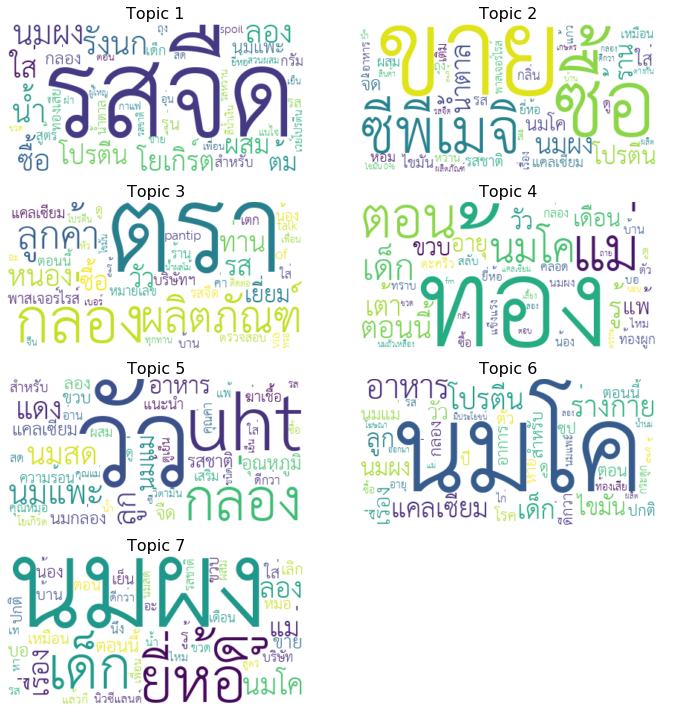

In [23]:
# REF: https://www.machinelearningplus.com/nlp/topic-modeling-visualization-how-to-present-results-lda-models/
topics = model.show_topics(num_topics=7, num_words=300,formatted=False)

# ตัดเศษคำหรือเทอมที่ไม่ต้องการออกก่อน (บางตัวเป็นชื่อแบรนด์ stopword หรือ Strong Ties)
rem = {'กิน','กินนม','ทาน','อร่อย','ชอบ','ออ','ดื่ม','ดื่มนม','ขอบคุณ','นม','ดูด','ทำ','//','ริ','หล่อ','แบบนี้','อาทิตย์','สัปดาห์'
       ,' ','','ดี','ผม','คน','เค้า','กระทู้','เหมือนกัน','อ่ะ','คลิก','ที่ซ่อน','pantipcom','พี่','ไม่ได้','ไม่มี','ข้อความ','เจอ'
       ,'ไทย','เดนมาร์ค','เดนมาร์ก','ดัชมิลล์','เมจิ','โฟร์โมสต์','โชคชัย','เวลา'
       ,'แดรี่โฮม','เอ็มมิลค์','แมคโนเลีย','ไทยเดนมาร์ค','หนองโพ','คาเนชั่น','บีทาเก้น','จิตรลดา'
       ,'tops','makro','lotus','bigc','7-Eleven','the'}
th_stopwords = set(thai_stopwords()).union(rem)
minProb = 0.001
maxProb = 0.01

fig, axes = plt.subplots(4, 2, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    try:
        fig.add_subplot(ax)
        topic_words = {a: b for a, b in topics[i][1] if a not in th_stopwords and (b >= minProb and b <= maxProb)}
        cloud.generate_from_frequencies(topic_words, max_font_size=300)
        plt.gca().imshow(cloud,interpolation='bilinear',cmap=plt.cm.gray)
        plt.gca().set_title('Topic ' + str(i+1), fontdict=dict(size=16))
        plt.gca().axis('off')
    except:
        print('num_topics less than matrix')

plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

### Export คำไปคัดเลือกอย่างละเอียด

สรุปคำที่จะนำมาเป็น Attribute (รวม link ที่เป็นเคสยกเว้น)

In [24]:
execption_urls = ['https://pantip.com/topic/30833944','https://pantip.com/topic/30105850','https://pantip.com/topic/35439062']

In [25]:
attrributes = ['เอ็มมิลค์','แดรี่โฮม','แมคโนเลีย','โชคชัย','โฟร์โมสต์','ไทยเดนมาร์ค','ไวตามิลค์','จิตรลดา','ซีพีเมจิ','ดัชมิลล์','หนองโพ'
               ,'7-Eleven','bigc','iso','lotus','makro','non-dairy whipping cream','tops','uht','vitamin','whipping','เก็บรักษา','เข้มข้น','เครื่องดื่มให้พลังงาน','เจมส์จิ'
               ,'เจริญอาหาร','เจลลาติน','เชื้อโรค','เชื้อรา','เซ็นทรัล','เต้าหู้','เต้าฮวย','เต้าฮวยนมสด','เท','เทนนิส','เทน้ำเทท่า','เนย','เนยสด','เนื้อไก่','เนื้อสัตว์','เบเกอรี่'
               ,'เบดไทม์','เป็นหวัด','เปรี้ยว','เพิ่มปริมาณ','เพื่อนรุ่นเดียวกัน','เฟซบุ้ค','เมจิโกลด์','เมจิไขมัน 0%','เมจิบัลแกเรีย','เมล่อน','เว็บไซต์','เหม็น','เอากำไร'
               ,'แก้ขัด','แกลลอน','แคนตาลูป','แครอท','แช่','แช่เย็น','แน่นท้อง','แนะนำ','แบบสอบถาม','แป้งข้าวโพด','แป้งสาลี','แพะ','แมกโนเลีย','แม็กซ์แวลู'
               ,'แลคตาซอย','แล็ป','แอลมอนด์','โกโก้','โกลเดนเพลส','โคนม','โครงการส่วนพระองค์','โครงการหลวง','โซดา','โฟมนม','โรงเรียน','โรงงาน','โรงพยาบาล'
               ,'โรบินสัน','โอวัลติน','โฮมเมด','ไข่','ไข่ไก่','ไขกระดูก','ไข่ขาว','ไข่ดาว','ไข่ต้ม','ไต','ไมโครเวฟ','ไม่ชอบ','ไม่อร่อย','ไหว้เจ้า','ไอศกรีม','กระทรวงพาณิชย์'
               ,'กระทรวงสาธารณสุข','กลมกล่อม','กล้วย','กล้วยน้ำว้า','กล้วยหอม','กล่อง','กลางดึก','กลาสเฟด','กลิ่น','กลิ่นคาว','การจัดส่ง','การบรรจุ','การปรุง','กินเจ'
               ,'กินรวบ','ขโมย','ขวด','ขวดนม','ของหวาน','ขาดตลาด','ข้าวเหนียว','ข้าวโพด','ข้าวโอ๊ต','ข้าวตัง','ข้าวสาลี','คนแก่','คนไข้','คนวัยหนุ่มสาว','คนสูงอายุ'
               ,'ครีมเทียม','ความแตกต่าง','คอนเฟลก','ค่าขนส่ง','คาราเมล','คาว','คุณหมอ','งานวิจัย','จิฟฟี่','จืดชืด','จุดขาย','ช็อกโกแลต','ช็อกโกแลตมิ้นต์','ชั่งใจ','ชา'
               ,'ชาเขียว','ชาเขียวมัจฉะ','ชาเมะมัทฉะ','ชาเย็น','ชาไทย','ชีวิตประจำวัน','ซัพพลายเออร์','ซากุระ','ซีเรียล','ซีพี','ดัชมิลล์','ดาร์คช็อกโกแลต','ดื่มนม','ต้ม'
               ,'ตัวแทนจำหน่าย','ติดใจ','ตีฟอง','ตู้เย็น','ถั่วเหลือง','ถุงพลาสติก','ถูกปาก','ถูกอกถูกใจ','ทวิตเตอร์','ท้องตลาด','ทำเงิน','ทำกำไร','ทำกิจกรรม'
               ,'ทำความสะอาด','ธัญพืช','นม','นมแพะ','นมโค','นมโรงเรียน','นมกล่อง','นมขวด','นมชง','นมถั่วเหลือง','นมผง','นมฟรีแลคโตส','นมยูเอชที','นมสด'
               ,'นมอัดเม็ด','นมอุ่น','น้ำเต้าหู้','น้ำนม','น้ำผลไม้','น้ำย่อย','น้ำหนัก','น้ำอัดลม','บรรจุขวด','บลูเบอร์รี่','บัตเตอร์','บาริสต้า','ประโยชน์','ประกอบอาหาร','ป่วย'
               ,'ผลไม้','ผลวิจัย','ผลิต','ผสม','ผู้สูงอายุ','ฝืดคอ','พนักงานขาย','พนักงานขายนม','พยาบาล','พระราชดำริ','พรีเซนเตอร์','พาสเจอร์ไรส์','ฟรอยด์','ฟอง'
               ,'ฟองเต้าหู้','ฟองนม','ฟองมัน','มหาลัย','มอลต์','มะพร้าวอ่อน','มะม่วง','มะละกอ','มังสวิรัติ','มัทฉะ','มันเทศ','มิลค์เชค','มีชื่อเสียง','มีประโยชน์','มื้อเช้า','มูส'
               ,'ยี่ห้อ','ยูเอชที','รสกล้วย','รสกาแฟ','รสจืด','รสชาติ','รสธรรมชาติ','รสหวาน','ร้านเบเกอรี่','ร้านกาแฟ','ร้านขายของชำ','ร้านค้า','ร้านนม','ร้านนมสด','รีดนม'
               ,'ลอง','ลาซาด้า','ลำไส้','ลูกเดือย','ลูกสุนัข','ลูกหมา','วอลนัท','วัยเด็ก','วัยเด็กเล็ก','วัวนม','วานิลลา','วาฟเฟิล','สเตรปโตคอคคัส','สเตอริไลซ์','สตรอว์เบอร์รี่'
               ,'สตาร์บัค','สบู่','สมูทตี้','สยามพารากอน','สลัด','ส่วนแบ่งการตลาด','ส่วนผสม','สะดวก','สารกันบูด','สูตรลดน้ำตาล','หมา','หลอด','หวาน','ห้องเย็น','หอม'
               ,'ห้างสรรพสินค้า','อเมซอน','อโวคาโด','อกไก่','อร่อย','ออร์แกนิค','อัลมอนด์','อาหารเจ','อาหารเสริม','อาหารว่าง','อีโคไล','อุตสาหกรรม','อุ่นนม','ฮอร์โมน'
               ,'ฮั่งก้วย','ฮาลาล','หางนม','เด็ก','เด็กเล็ก','เด็กแรกเกิด','เด็กโต','เด็กผู้ชาย','เด็กวัยเรียน','เด็กอ่อน','เลี้ยงลูก','แปรงฟัน','แพ้ท้อง','แม่','แม่ลูกอ่อน','ให้นม'
               ,'คนท้อง','คลอด','คลอดลูก','คุณแม่','ชงนม','ตั้งครรภ์','ตั้งท้อง','ท้อง','นมแม่','ประถม','ฝากครรภ์','ฝากท้อง','มีครรภ์','มีครอบครัว','มีลูก','ลูก','ลูกชาย'
               ,'ลูกสาว','หย่านม','แถม','แพคคู่','โปรโมชั่น','โปรโมต','การลดราคา','ของแถม','ชิม','ลดราคา','อาหาร','เอสเพรสโซ่','โอวัลติน','โฮลวีท','ไมโล','กาแฟ'
               ,'กาแฟเย็น','กาแฟร้อน','กาแฟสด','ขนม','ขนมเค้ก','ขนมปัง','ขนมหวาน','คาปูชิโน','ชง','ชงกาแฟ','ทำฟอง','ทำอาหาร','มอคค่า','ลาเต้','อเมริกาโน'
               ,'haccp','เหม็นเปรี้ยว','เหม็นบูด','แบคทีเรีย','กระบวนการผลิต','การบูด','ของเสีย','ความสะอาด','คุณภาพ','ตะกอน','บรรจุภัณฑ์','บุบ','บูด','ปนเปื้อน','ปริมาตร'
               ,'วันหมดอายุ','สะอาด','สารเคมี','สารสังเคราะห์','สิ่งแปลกปลอม','สิ่งปลอมปน','หมดอายุ','ความคุ้มค่า','คุ้มค่า','ราคาแพง','ราคาถูก','dha','เวย์โปรตีน'
               ,'แคลเซียม','แป้ง','แมกนีเซียม','แลคโตส','แลคติก','แอนโดรเจน','แอนตี้ไบโอติก','แอลคานีทีน','โซเดียม','โปรตีน','โพแทสเซียม','โฟเลต','โอเมก้า','ไขมัน'
               ,'ไมอิลีน','ไอโอดีน','กรดอะมิโน','กลูโคส','กาเฟอีน','กาแลกโตส','กาแลคโตส','คาเฟอีน','คาร์โบไฮเดรต','ซูโครส','ธาตุเหล็ก','ธาตุอาหาร','น้ำ','น้ำตาล','น้ำตาลเทียม'
               ,'น้ำตาลทราย','น้ำตาลทรายแดง','วิตามิน','สารอาหาร','อาร์จีนีน','whey formula','เครียด','เตี้ย','เบาหวาน','เพาะกาย','เพิ่มน้ำหนัก','เล่นเวท','เล่นกล้าม'
               ,'เวย์โปรตีน','เสริมสร้างกระดูก','เสริมสร้างร่างกาย','เอนไซม์','แข็งแรง','แคลอรี่','แพ้','แพ้นม','โด๊ป','โภชนาการ','โรคเบาหวาน','โรคโลหิตจาง','โรคประจำตัว'
               ,'โรคมะเร็ง','โลหิตจาง','ไขมัน 0%','ไขมันต่ำ','ไขมันทรานส์','ไฮแคลเซียม','ไฮโปรตีน','กรดไขมัน','กรดอะมิโน','กระเพาะ','กระเพาะอาหาร','กระดูก','กระดูกแข็งแรง'
               ,'กระดูกพรุน','กระดูกสันหลัง','กระดูกอ่อน','กล้าม','กล้ามเนื้อ','การเจริญเติบโต','การเล่นกีฬา','การฉายแสง','การย่อยอาหาร','การลดน้ำหนัก','การออกกำลังกาย'
               ,'ขับถ่าย','ขาดสารอาหาร','คลื่นไส้','ความดัน','ความสูง','ความหวาน','ความอ้วน','คอเลสเตอรอล','คอลลาเจน','คุณประโยชน์','คุมอาหาร','ช่องท้อง','ชั่งน้ำหนัก'
               ,'ซ่อมแซมส่วนที่สึกหรอ','ดูแลสุขภาพ','ตัวเตี้ย','ตัวเล็ก','ตัวสูง','ท้องเสีย','ท้องผูก','ท้องร่วง','ท้องว่าง','ท้องอืด','นอนหลับ','นักโภชนาการ','นักกีฬา','บำรุง','บำรุงกำลัง'
               ,'ปวดท้อง','ผิดปกติ','พลังงาน','พิษสุนัขบ้า','ฟันผุ','ฟิต','ฟิตเนส','ฟื้นฟูสภาพ','ภูมิแพ้','มวลกระดูก','มะเร็ง','ระบบขับถ่าย','รักษาสุขภาพ','ลดความอ้วน','ลดน้ำหนัก'
               ,'ส่วนสูง','สุขภาพ','สุขอนามัย','สูง','หลังอาหาร','หายป่วย','อดอาหาร','อยากสูง','ออกกำลัง','ออกกำลังกาย','อะมิโน','อักเสบ','อัลบูมิน','อาเจียน','เป็นประจำ','ไม่คุ้มค่า'
               ,'ขาย','ขายไม่ดี','ขายไม่ออก','ขายดี','ขายปลีก','ขายส่ง','ซื้อประจำ','หาซื้อ','หายาก','หาซื้อไม่ได้']

stores = ['tops','makro','lotus','bigc','7-Eleven']

products = ['สตรอว์เบอร์รี','ช็อกโกแลต','รสกาแฟ','รสหวาน','รสจืด','ไขมันต่ำ','ไขมัน 0%','ไฮโปรตีน','อัลมอนด์'
                ,'รสกล้วย','grass fed','นมฟรีแลคโตส','เมจิโกลด์','นมฮอกไกโด','เบดไทม์','ดาร์คช็อกโกแลต','ไฮแคลเซียม'
                ,'คาราเมล','มอลต์','เมล่อน','ชาเขียวมัจฉะ','บัลแกเรีย','รสธรรมชาติ','รสกลมกล่อม','ซากุระ','วิปครีม']

milk_kind=['นม','นมข้น','นมจืด','นมสด','กินนม','ดื่มนม','ขวดนม','นมวัว','นมกล่อง','ผลิตภันท์นม','น้ำนมโค'
                     ,'โยเกิร์ต','นมเปรี้ยว','uht','นมถั่วเหลือง','นมผง','พาสเจอร์ไรส์','nondairy','non dairy']

#  EDA ใน Excel ได้ flavor 68 ตัว (ถ้าดึงยี่ห้ออื่นก็เพิ่มอีก)
#avai_flavs = ['เมจิเมจิโกลด์','เมจิเมล่อน','เมจิไขมัน 0%','เมจิไขมันต่ำ','เมจิไฮโปรตีน','เมจิช็อกโกแลต','เมจิชาเขียวมัจฉะ','เมจิดาร์คช็อกโกแลต'
# ,'เมจินมฟรีแลคโตส','เมจิบัลแกเรีย','เมจิมอลต์','เมจิรสกลมกล่อม','เมจิรสกล้วย','เมจิรกาแฟ','เมจิรสจืด','เมจิรสธรรมชาติ','เมจิรสหวาน'
# ,'เมจิสตรอว์เบอร์รี','เมจิอัลมอนด์','เอ็มมิลค์นมฟรีแลคโตส','เอ็มมิลค์รสจืด','แดรี่โฮมgrass fed','แดรี่โฮมเบดไทม์','แดรี่โฮมช็อกโกแลต'
# ,'แดรี่โฮมรสกล้วย','แดโฮมรสจืด','แดรี่โฮมรสหวาน','แดรี่โฮมสตรอว์เบอร์รี','แมคโนเลียไขมันต่ำ','แมคโนเลียช็อกโกแลต','แมคโนเลียรสจืด'
# ,'โชคชัยไขมันต่ำ','โชคชัยช็อกโกแลต','โชคชัยรสกาแฟ','โชคชัยรสจืด','โชคชัยสตรอว์เบอร์รี','ฟร์โมสต์ไขมัน 0%','โฟร์โมสต์ไขมันต่ำ'
# ,'โฟร์โมสต์คาราเมล','โฟร์โมสต์ช็อกโกแลต','โฟร์โมสต์รสกาแฟ','โฟร์โมสต์รสจืด','โฟร์โมสต์สตรอว์เบอร์รี','ไทยเดนมาร์คช็อกโกแลต'
# ,'ไทยเดนมาร์ครสกาแฟ','ไทยเดนมาร์ครสจืด','ไทยเดนมาร์ครสหวาน','ไทยเดนมาร์คสตรอว์เบอร์รี','คาเนชั่นรสจืด','จิตรลดาช็อกโกแลต'
# ,'จิตรลดารสจืด','จิตรลดารสหวาน','จิตรลดาสตรอว์เบอร์รี','ดัชมิลล์ไขมัน 0%','ดัชมิลล์ไขมันต่ำ','ดัชมิลล์ไฮโปรตีน','ดัชลล์อกกแลต'
# ,'ดัชมิลล์มอลต์','ดัชมิลล์รสกาแฟ','ดัชมิลล์รสจืด','ดัชมิลล์สตรอว์เบอร์รี','หนองโพไขมัน 0%','หนองโพไขมันต่ำ','หนองโพช็อกโกแลต'
# ,'หนองโพรสกาแฟ','หนองโพรสจืด','หนองโพรสหวาน','หนองโพสตรอว์เบอร์รี']

reduceCol = attrributes
#reduceCol = attrributes + stores
#reduceCol_all = attrributes + stores + milk_kind + products

In [26]:
print(len(attrributes))
print(len(reduceCol))

526
526


### 5.สร้าง (Reduce) Bag of word ด้วย dictionary.doc2bow จัดลง dataframe

In [27]:
cursor_thread = col_thread.find()
df_thr_process = pd.DataFrame(cursor_thread)
cursor_comment = col_comment.find()
df_cmt_process = pd.DataFrame(cursor_comment)

In [28]:
# คัด headline ที่พูดถึง domain นม
df_urls_milk = df_thr_process[(df_thr_process.t_mention_dairy.str.len() != 0) | (df_thr_process.URLs.isin(execption_urls))]
#df_urls_milk = df_thr_process[(df_thr_process.URLs.isin(execption_urls))]

In [29]:
# เมื่อ join กันแล้ว คอมเม้นทุกคอมเม้นจะอยู่ใน domain นมทั้งหมด
df_join_url = pd.merge(df_urls_milk,df_cmt_process,how='inner',on='URLs')

In [30]:
df_join_url.drop(columns=['_id_x','_id_y','headline_y'],inplace=True)
df_join_url.rename(columns={"headline_x":"headline"},inplace=True)

In [31]:
df_join_url['token_text_reduce'] = df_join_url['token_text'].apply(lambda x: reduced_keyword(x, reduceCol))

### 6.ทำ Topic Modeling จาก Reduce BoW

6.1 สร้าง Bag of word

In [32]:
dictionary = gensim.corpora.Dictionary(df_join_url['token_text_reduce'])
gensim_corpus = [dictionary.doc2bow(text, allow_update=True) for text in df_join_url['token_text_reduce']]
word_frequencies = [[(dictionary[id], frequence) for id, frequence in couple] for couple in gensim_corpus]
id2word = dictionary.id2token

6.2 หา Optimal Dimension

In [33]:
#mlp = r'E:/master_BADS/IS_BADS/Product-Position-SNA/mallet-2.0.8/'
#mlp = r'D:/development_TestCase/Product-Position-SNA/mallet-2.0.8/'
#import os
#from gensim.models.wrappers import LdaMallet
#from gensim.models import CoherenceModel
#os.environ.update({'MALLET_HOME':mlp})

In [34]:
#mallet_path = "D:/development_TestCase/Product-Position-SNA/mallet-2.0.8/bin/mallet"
#mallet_path = "E:/master_BADS/IS_BADS/Product-Position-SNA/mallet-2.0.8/bin/mallet"
#limit=20; start=1; step=1;
#coherence_values = []
#model_list = []
#for num_topics in range(start, limit, step):
#    model = LdaMallet(mallet_path, corpus=gensim_corpus, num_topics=num_topics, id2word=id2word)
#    model_list.append(model)
#    coherencemodel = CoherenceModel(model=model, texts=df_join_url['token_text_reduce'], dictionary=dictionary, coherence='c_v')
#    coherence_values.append(coherencemodel.get_coherence())

In [35]:
#coherence_values

In [36]:
#model.show_topics(formatted=False)

In [37]:
# Show graph
#x = range(start, limit, step)
#plt.plot(x, coherence_values)
#plt.xlabel("Num Topics")
#plt.ylabel("Coherence score")
#plt.legend(("coherence_values"), loc='best')
#plt.show()

In [38]:
# Print the coherence scores
#for m, cv in zip(x, coherence_values):
#    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

6.3 สร้าง LdaModel ตามกลุ่มที่หาได้

In [55]:
num_topics = 8
chunksize = 1000                  # size of the doc looked at every pass
iterations = 25
eval_every = 1                    # Don't evaluate model perplexity, takes too much time.

%time model = gensim.models.LdaModel(corpus=gensim_corpus, id2word=id2word, chunksize=chunksize \
                                     ,alpha='auto', eta='auto',iterations=iterations \
                                     ,num_topics=num_topics \
                                     , eval_every=eval_every)

Wall time: 10 s


In [56]:
pyLDAvis.gensim.prepare(model, gensim_corpus, dictionary, R=40, lambda_step=0.05)
#pyLDAvis.gensim.prepare(model, gensim_corpus, dictionary, R=40, lambda_step=0.1, mds='tsne')

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4     -0.105016  0.043836  1       1        15.909981
3      0.244830  0.163497  2       1        15.708676
7      0.158772 -0.268390  3       1        14.457984
1      0.035539 -0.166343  4       1        13.298600
6     -0.007169  0.146492  5       1        11.506763
0      0.108974  0.138779  6       1        11.326530
5     -0.326414  0.033711  7       1        10.314846
2     -0.109515 -0.091582  8       1        7.476619 , topic_info=        Term         Freq        Total Category  logprob  loglift
39   ลูก      4840.000000  4840.000000  Default  40.0000  40.0000
31   อร่อย    2162.000000  2162.000000  Default  39.0000  39.0000
51   กล่อง    3116.000000  3116.000000  Default  38.0000  38.0000
220  นมแม่    2342.000000  2342.000000  Default  37.0000  37.0000
61   นมผง     3177.000000  3177.000000  Default  36.0000  36.0000
..    ...             ...          ...      ...      ...      ...
1    ขวด      79.479438    1470.618048  Topic8  -4.4900  -0.3246 
96   พลังงาน  27.811660    108.456536   Topic8  -5.5400   1.2325 
61   นมผง     70.552016    3177.596013  Topic8  -4.6091  -1.2141 
19   ต้ม      32.264497    260.094805   Topic8  -5.3915   0.5063 
21   รสชาติ   33.545636    1232.527641  Topic8  -5.3526  -1.0105 

[521 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
0     6      0.081356  7-Eleven 
0     7      0.085230  7-Eleven 
0     8      0.825185  7-Eleven 
354   2      0.050996  dha      
354   3      0.917921  dha      
...  ..           ...  ...      
277   6      0.900887  ไวตามิลค์
176   1      0.082267  ไอศกรีม  
176   8      0.911266  ไอศกรีม  
224   3      0.333441  ไฮโปรตีน 
224   8      0.583522  ไฮโปรตีน 

[835 rows x 3 columns], R=40, lambda_step=0.05, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 4, 8, 2, 7, 1, 6, 3])

In [57]:
cloud = WordCloud(font_path='thsarabunnew-webfont.ttf',background_color='white',max_words=40)

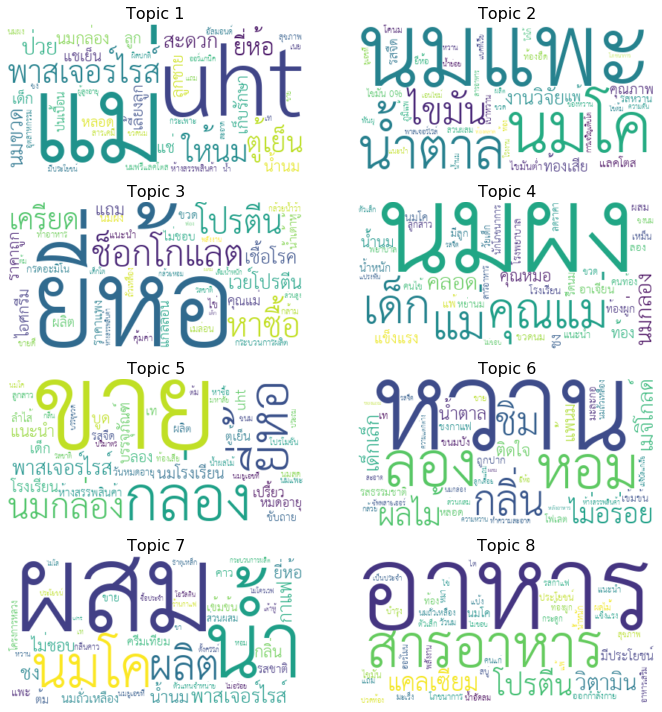

In [65]:
# REF: https://www.machinelearningplus.com/nlp/topic-modeling-visualization-how-to-present-results-lda-models/

topics = model.show_topics(num_topics=model.num_topics, num_words=300,formatted=False)

# ตัดเศษคำหรือเทอมที่ไม่ต้องการออกก่อน (บางตัวเป็นชื่อแบรนด์ stopword หรือ Strong Ties)
rem = {'กิน','กินนม','ทาน','อร่อย','ชอบ','ออ','ดื่ม','ดื่มนม','ขอบคุณ','นม','ดูด','ทำ','//','ริ','หล่อ','แบบนี้','อาทิตย์','สัปดาห์'
       ,' ','','ดี','ผม','คน','เค้า','กระทู้','เหมือนกัน','อ่ะ','คลิก','ที่ซ่อน','pantipcom','พี่','ไม่ได้','ไม่มี','ข้อความ','เจอ'
       ,'ไทย','เดนมาร์ค','เดนมาร์ก','ดัชมิลล์','ซีพีเมจิ','โฟร์โมสต์','โชคชัย','เวลา'
       ,'แดรี่โฮม','เอ็มมิลค์','แมคโนเลีย','ไทยเดนมาร์ค','หนองโพ','คาเนชั่น','บีทาเก้น','จิตรลดา'
       ,'tops','makro','lotus','bigc','7-Eleven','the'}
th_stopwords = set(thai_stopwords()).union(rem)
minProb = 0.001
maxProb = 0.1

fig, axes = plt.subplots(4, 2, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    try:
        fig.add_subplot(ax)
        topic_words = {a: b for a, b in topics[i][1] if a not in th_stopwords and (b >= minProb and b <= maxProb)}
        cloud.generate_from_frequencies(topic_words, max_font_size=300)
        plt.gca().imshow(cloud,interpolation='bilinear',cmap=plt.cm.gray)
        plt.gca().set_title('Topic ' + str(i+1), fontdict=dict(size=16))
        plt.gca().axis('off')
    except:
        print("An exception occurred")

plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

In [66]:
topics = [[(term, round(wt, 3)) for term, wt in model.show_topic(n, topn=40)] for n in range(0, model.num_topics)]
# set column width
pd.set_option('display.max_colwidth', 1)
topics_df = pd.DataFrame([', '.join([term for term, wt in topic]) for topic in topics], columns = ['Terms per Topic'], index=['Topic'+str(t) for t in range(1, model.num_topics+1)] )
topics_df

,Terms per Topic
Topic1,"นม, ขวด, แม่, uht, พาสเจอร์ไรส์, ให้นม, ตู้เย็น, ยี่ห้อ, ป่วย, นมขวด, สะดวก, นมกล่อง, แช่, เก็บรักษา, ลูกชาย, น้ำนม, เลี้ยงลูก, เด็ก, แช่เย็น, ลูก, หลอด, ปนเปื้อน, ห้างสรรพสินค้า, นมฟรีแลคโตส, ชง, อัลมอนด์, กระเพาะ, สุขภาพ, นมผง, เท, สารเคมี, อุตสาหกรรม, เนย, สะอาด, น้ำ, ผิดปกติ, ออร์แกนิค, มีประโยชน์, ขาย, ผู้สูงอายุ"
Topic2,"นม, นมแพะ, นมโค, น้ำตาล, ดื่มนม, จิตรลดา, ไขมัน, งานวิจัย, ซีพีเมจิ, ท้องเสีย, คุณภาพ, แพ้, รสจืด, แลคโตส, รสหวาน, ไขมันต่ำ, ไขมัน 0%, ท้องอืด, ยี่ห้อ, เบาหวาน, ภูมิแพ้, โคนม, ส่วนผสม, โรงงาน, น้ำนม, ยูเอชที, โกโก้, ท้อง, เอนไซม์, พาสเจอร์ไรส์, ขวด, ของหวาน, แบคทีเรีย, ไข่ต้ม, การเจริญเติบโต, หวาน, น้ำย่อย, แนะนำ, ฟันผุ, ผลิต"
Topic3,"ลอง, นม, โชคชัย, ยี่ห้อ, ช็อกโกแลต, หาซื้อ, โปรตีน, เครียด, 7-Eleven, เวย์โปรตีน, เชื้อโรค, ดัชมิลล์, แถม, ราคาถูก, ไอศกรีม, ซีพีเมจิ, แกลลอน, ผลิต, คุณแม่, ราคาแพง, น้ำเต้าหู้, ขวด, ไม่ชอบ, นมผง, ไข่, กรดอะมิโน, แนะนำ, เมล่อน, กระบวนการผลิต, ทำอาหาร, ถั่วเหลือง, คุ้มค่า, กล้าม, ขายดี, กล้วยน้ำว้า, รสชาติ, ต้ม, เด็กโต, กล้วยหอม, พลังงาน"
Topic4,"ลูก, นมแม่, นมผง, นม, คุณแม่, เด็ก, แม่, คลอด, นมกล่อง, คุณหมอ, ชง, น้ำนม, แข็งแรง, ท้อง, อาเจียน, แพ้, รีดนม, ท้องผูก, น้ำหนัก, นมโค, ขวดนม, แนะนำ, โรงเรียน, มีลูก, ลอง, ผสม, โรงพยาบาล, คนไข้, โฟร์โมสต์, หย่านม, ลูกสาว, คนท้อง, วัยเด็ก, ขวด, เหม็น, นักโภชนาการ, ลดราคา, พยาบาล, สารอาหาร, ชงนม"
Topic5,"นม, ขาย, กล่อง, ยี่ห้อ, ไทยเดนมาร์ค, หนองโพ, โฟร์โมสต์, นมกล่อง, พาสเจอร์ไรส์, แนะนำ, บูด, นมโรงเรียน, โรงเรียน, บรรจุภัณฑ์, ลอง, เด็ก, uht, เปรี้ยว, หมดอายุ, เท, ตู้เย็น, ห้างสรรพสินค้า, ดัชมิลล์, ผลิต, รสจืด, ลำไส้, ขับถ่าย, วันหมดอายุ, ลูกสาว, นมสด, น้ำผลไม้, โปรโมชั่น, หาซื้อ, ท้องเสีย, ต้ม, ขนม, นมแพะ, นมยูเอชที, มหาลัย, ประถม"
Topic6,"อร่อย, กล่อง, รสชาติ, หวาน, ลอง, หอม, นม, กลิ่น, ชิม, ผลไม้, ซีพีเมจิ, ไม่อร่อย, ดัชมิลล์, โฟร์โมสต์, แดรี่โฮม, เมจิโกลด์, เด็กเล็ก, น้ำตาล, ติดใจ, แพ้นม, รสธรรมชาติ, เท, หลอด, ถูกปาก, มะละกอ, ชงกาแฟ, ขนมปัง, เข้มข้น, โฟเลต, ขาย, นมถั่วเหลือง, ทำความสะอาด, ส่วนผสม, กล้วย, แถม, ความหวาน, ซัพพลายเออร์, ไทยเดนมาร์ค, ยี่ห้อ, 7-Eleven"
Topic7,"นมผง, นมสด, ผสม, นม, น้ำ, นมโค, ผลิต, พาสเจอร์ไรส์, ชง, กาแฟ, น้ำนม, ไม่ชอบ, กลิ่น, ยี่ห้อ, นมถั่วเหลือง, ต้ม, คาว, ครีมเทียม, เข้มข้น, รสชาติ, แพะ, ขาย, โครงการหลวง, ส่วนผสม, อร่อย, กลิ่นคาว, ตั้งครรภ์, ธาตุเหล็ก, ชา, ตัวแทนจำหน่าย, ไม่อร่อย, หวาน, เท, หอม, นมยูเอชที, uht, โอวัลติน, ไมโล, ประโยชน์, กระบวนการผลิต"
Topic8,"เด็ก, สูง, อาหาร, นม, สารอาหาร, โปรตีน, แคลเซียม, วิตามิน, มีประโยชน์, นมโค, ดื่มนม, ท้อง, ประโยชน์, ไขมัน, แนะนำ, โภชนาการ, ออกกำลังกาย, น้ำหนัก, ผลไม้, บำรุง, นมถั่วเหลือง, กระดูก, วัวนม, อาหารเสริม, ฮอร์โมน, แพ้, ท้องผูก, สบู่, แป้ง, หมา, สุขภาพ, แข็งแรง, มะเร็ง, รสกาแฟ, คนแก่, ไข่, ไต, น้ำอัดลม, ตัวเล็ก, พลังงาน"


### Pre-trained USE(Universal Sentence Encoder)<br>
ใช้ ML และ Algebra กำหนดชื่อ Category (ทดลองทำ)

In [ ]:
#pip install tensorflow-text==2.4.1
import tensorflow_hub as hub
import tensorflow_text
import tensorflow as tf

In [ ]:
# create USE embedding by using tensorflow hub
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder-multilingual/3")

In [ ]:
emb_other_interest = embed(attrributes).numpy()
df_emb_oth_interest = pd.DataFrame(emb_other_interest,index = attrributes)
df_emb_oth_interest.head(10)

In [ ]:
set_category = [ 'แม่และเด็ก', 'สารอาหาร', 'โปรโมชั่น', 'สุขภาพ', 'มาตรฐาน','นม', 'ขนม', 'กาแฟ', 'อาหาร', 'ราคา', 'ยี่ห้อ', 'ร้าน']

# create df which contains embedded vector of selected category
df_emb_category = pd.DataFrame(embed(set_category).numpy(), index = set_category)
df_emb_category.head()

In [ ]:
argmax_category = df_emb_oth_interest.dot(df_emb_category.T).idxmax('columns').values
df_result = pd.DataFrame({
                        'original_text' : df_emb_oth_interest.index,
                        'category' : argmax_category
                      })
df_result.iloc[30:50]

สรุป...USE ใช้กับงานนี้ไม่ดีเท่าที่ควร